In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Imputation Accuracy Assessment Using VCF Files

In [3]:
imputed = "./f250_imputed.300.chr21.dose.vcf"
true = "./f250_validation.300.chr21.recode.vcf"

* reads in imputed vcf file with dosage information
* outputs dictionary with snps as keys, and ordered list of dosage genotypes as values

In [4]:
impdict = {}
ids = []
with open(imputed, "r") as imp:
    for line in imp:
        if not line.startswith("#"):
            pos = line.split("\t")[2]
            gen = line.split("\t")[9:]
            genotypes = [x.split("|") for x in gen]
            alt = [float(x[1].split(":")[1]) for x in genotypes]
            impdict[pos] = alt
        if line.startswith("#"):
            ids.append(line)
samples = ids[-1].split("\t")[9:]
impdf = pd.DataFrame.from_dict(impdict, orient='index')
impdf.columns = samples

In [5]:
truedict = {}
trueids = []
with open(true, "r") as t:
    for line in t:
        if not line.startswith("#"):
            cp = (line.split("\t")[0], line.split("\t")[1])
            pos = ":".join(cp)
            gen = line.split("\t")[9:]
            genotypes = [(x.split("|")) for x in gen]
            intgt = [[int(y) for y in x ]for x in genotypes]
            alt = [sum(x) for x in intgt]
            truedict[pos] = alt
        if line.startswith("#"):
            trueids.append(line)
samples = trueids[-1].split("\t")[9:]
truedf = pd.DataFrame.from_dict(truedict, orient='index')
truedf.columns = samples

* correlation is calculated between the two dataframes (imputed and truth sets) on a marker-by-marker basis
* stored in correlation dataframe with the chr:pos as the index, and animals as columns
* chr:pos will allow for full assay imp accuracy to be calculated at once

In [6]:
corrs=impdf.corrwith(truedf, axis = 1)
cor = pd.DataFrame(corrs)
cor = cor.rename(index=str, columns={0:"correlation"})

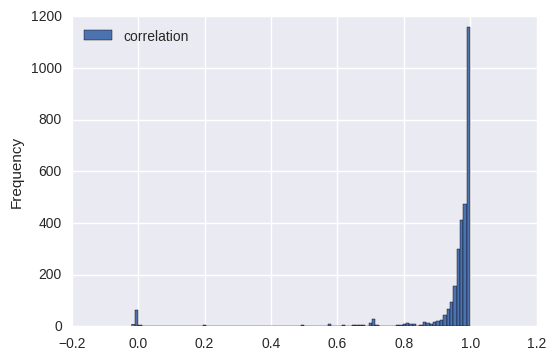

In [7]:
cor.plot.hist(bins = 100)

# MAF Calculations
* This will use MAF from a .frq file for all animals genotyped on the assay
* frq file has only id, not position
* In order to match MAF to correlations, we need to add position information in from .map file.  

In [8]:
frq = "./227234.161117.12083.100_B.frq"
mapfile = "./9913_GGPF250_161214.map"

In [9]:
freq = pd.read_table(frq, delim_whitespace=True)
del freq['A1'] 
del freq['A2']
del freq['NCHROBS'] 
freq.head()

,CHR,SNP,MAF
0,0,3494,0.1361
1,0,4688,0.3092
2,0,24807,0.3321
3,0,24946,0.4774
4,0,5216,0.3901


* This leaves a dataframe with chromosome, snp_id, and MAF

In [10]:
map = pd.read_table(mapfile, delim_whitespace=True, header=None)

In [11]:
map.columns = ("CHR", "SNP", "CM", "POS")

In [12]:
map21 = map.loc[map['CHR'] == 21]

In [13]:
freq_map_merged = pd.merge(map21, freq, on=("SNP","CHR"), how='inner')
freq_map_merged.head()

,CHR,SNP,CM,POS,MAF
0,21,282784,31.3717,31371711,1.000000
1,21,283866,10.7432,10743235,0.095830
2,21,283867,10.7974,10797397,0.000714
3,21,283868,10.7978,10797770,0.000042
4,21,283869,10.7978,10797779,0.000126


In [14]:
posmaf = freq_map_merged[["CHR","POS","MAF"]]
posmaf.index = posmaf.CHR.astype(str).str.cat(posmaf.POS.astype(str), sep = ':')

In [15]:
del posmaf.index.name

In [16]:
filter = posmaf["MAF"] <= 0.5
maffiltered = posmaf[filter]

In [17]:
mafcor = cor.join(maffiltered)
mafcor.head()

,correlation,CHR,POS,MAF
21:20086847,NaN,21.0,20086847.0,0.000174
21:50244488,0.994097,21.0,50244488.0,0.295700
21:49530646,NaN,21.0,49530646.0,0.000706
21:28220620,NaN,21.0,28220620.0,0.000704
21:68639904,NaN,NaN,NaN,NaN


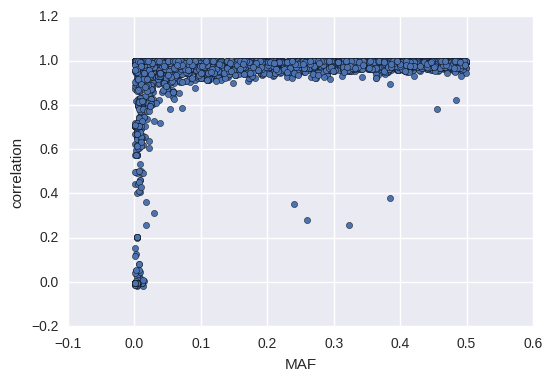

In [18]:
mafcor.plot.scatter(x = "MAF", y = "correlation")

In [19]:
MAF = mafcor['MAF']

In [27]:
plotter = pd.DataFrame(MAF)
plotter["ACC"] = mafcor["correlation"]
bins = np.linspace(0,.5,100)
plotter_na = plotter[(-2<plotter['ACC']) & (plotter['ACC']<2)]
print (plotter_na.describe())
a_bins = plotter_na.groupby(pd.cut(plotter_na['MAF'],bins))

               MAF          ACC
count  3082.000000  3082.000000
mean      0.223365     0.930258
std       0.160536     0.183349
min       0.000166    -0.019192
25%       0.068378     0.960294
50%       0.223100     0.981899
75%       0.371925     0.995711
max       0.499800     1.000000


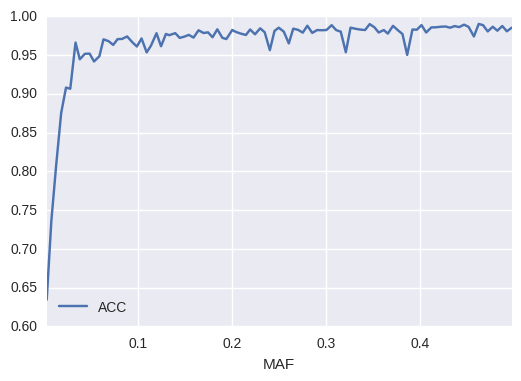

In [37]:
a_bins.mean().plot(x='MAF',y='ACC')